# ADA Project: MileStone2

## While way-finding in information network, human is a *Genius* or a *Lazybone*?

*Wikipeedia* is a human-computation game based on articles in Wikipedia. Users are asked to navigate from a source article to a specific target one, through clicking the links appeared in each Wikipedia article. Different from how a computer plays the game, humans will not always choose the shortest path to reach the destination word from the source one.
We summary the human's "clicking process" into two main steps:
<ol>
<li>People first establish a logical chain (clear or blurry) which connect the source word to the destination, preliminarily. This part is based on people's priori knowledge.</li>
<br>
<li>While scanning the HTML page, people change their initial logical chain and finish their "clicking task". People make their shift according to the HTML they see, i.e. textplain, images in the page. </li>
</ol>

We will process our analyse according to this two steps. In the first part, we use the model LDA to grasp points about how people link the source and target. In the second stage, we analyze the finished path and unfinished path to find people's clicking tendency based on the article they scan.

### Content

1. Basic analysis on the dataset
2. Logical chain exploration using the LDA model
3. Clicking tendency based on HTML pages


### Useful libraries

In [85]:
# Utilitaries
import pandas as pd
import os

# Math
import numpy as np
from scipy import stats

# Plot
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 100)

### Data Importation

We will import the data in file "paths_finished.tsv", "article.tsv" and "categories.tsv" into DataFrame

In [87]:
# Reading the 'paths_finished.tsv' file as a pandas dataframe
PATH_DATASET = "../dataset"
fname = os.path.join(PATH_DATASET, 'wikispeedia_paths-and-graph/paths_finished.tsv')
df_finished_path = pd.read_csv("../dataset/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', comment = '#', header=None, names = ['hashedIpAddress','timestamp','durationInSec','path','rating'], encoding = 'UTF-8')

df_finished_path.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F...,3.0


In [88]:
# Reading the 'categories.tsv' file as a pandas dataframe

fname = os.path.join(PATH_DATASET, 'wikispeedia_paths-and-graph/categories.tsv')
df_catagories = pd.read_csv(fname, sep = '\t', comment = '#', header = None, names = ['articles','category'], encoding = 'UTF-8')
df_catagories.head()

,articles,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_Countries
4,%C3%89douard_Manet,subject.People.Artists


In [95]:
# Reading the 'articles.tsv' file as a pandas dataframe

fname = os.path.join(PATH_DATASET, 'wikispeedia_paths-and-graph/articles.tsv')
df_article = pd.read_csv(fname, sep = '\t', comment = '#', header = None, names = ['articles'],encoding = 'UTF-8')
df_article.head()

,articles
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


### First glance at the data

We first analyse each file, respectively. And then we will merge files together to delve more points.

#### Analyse each file independently. We will generate more datas in the dataframe.
Files are "paths_finished.tsv" and "categories.tsv"

**1. paths_finished.tsv**

We calculate the path length and store the value in column **path_length**. For example if the path is "Yagan; Ancient_Egypt; Civilization", the path length is 2.

In [89]:
def calculate_path_length(x):
    string_array = x.split(';')
    return len(string_array)-1

df_finished_path['path_length'] = df_finished_path['path'].apply(calculate_path_length)

We extract the source and the target word from the path and store them in column **source** and **destination**, respectively.

In [92]:
def path_source(x):
    string_array = x.split(';')
    return string_array[0]


def path_destination(x):
    string_array = x.split(';')
    return string_array[-1]

df_finished_path['source'] = df_finished_path['path'].apply(path_source)
df_finished_path['destination'] = df_finished_path['path'].apply(path_destination)

We construct the data "path pair". For example, if the path is "A; B; C", then the path pair will be [(A, B), (B, C)]

In [93]:
df_finished_path['path_pair'] = None

i = 0
path_pair_dict = {}
for index, row in df_finished_path['path'].items():
    string_path_pair = []
    string_array = row.split(";")
    for pair_index in range(len(string_array) - 1):
        string_pair = '(' + string_array[pair_index] + ', ' + string_array[pair_index + 1] + ')'
        string_path_pair.append(string_pair)
        path_pair_dict[string_pair] = path_pair_dict.get(string_pair, 0) + 1
    df_finished_path['path_pair'][i] = string_path_pair
    i += 1

In [94]:
df_finished_path.head(10)

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,source,destination,path_pair
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_...,NaN,8,14th_century,African_slave_trade,"[(14th_century, 15th_century), (15th_century, 16th_century), (16th_century, Pacific_Ocean), (Pac..."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0,4,14th_century,African_slave_trade,"[(14th_century, Europe), (Europe, Africa), (Africa, Atlantic_slave_trade), (Atlantic_slave_trade..."
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN,7,14th_century,African_slave_trade,"[(14th_century, Niger), (Niger, Nigeria), (Nigeria, British_Empire), (British_Empire, Slavery), ..."
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,3,14th_century,Greece,"[(14th_century, Renaissance), (Renaissance, Ancient_Greece), (Ancient_Greece, Greece)]"
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F...,3.0,6,14th_century,John_F._Kennedy,"[(14th_century, Italy), (Italy, Roman_Catholic_Church), (Roman_Catholic_Church, HIV), (HIV, Rona..."
5,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_States;President_of_the_United_States;John_F._Kennedy,NaN,5,14th_century,John_F._Kennedy,"[(14th_century, Europe), (Europe, North_America), (North_America, United_States), (United_States..."
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,2.0,3,14th_century,Fire,"[(14th_century, China), (China, Gunpowder), (Gunpowder, Fire)]"
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rainbow,1.0,5,14th_century,Rainbow,"[(14th_century, Time), (Time, Isaac_Newton), (Isaac_Newton, Light), (Light, Color), (Color, Rain..."
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,3.0,3,14th_century,Rainbow,"[(14th_century, Time), (Time, Light), (Light, Rainbow)]"
9,08888b1b428dd90e,1232241601,167,14th_century;15th_century;Plato;Nature;Ultraviolet;Color;Rainbow,NaN,6,14th_century,Rainbow,"[(14th_century, 15th_century), (15th_century, Plato), (Plato, Nature), (Nature, Ultraviolet), (U..."


Dataframe **df_finished_path** variables

`hashedIpAddress`: IP address in hashed format. It is the unique identifier.

`timestamp`: timestamp when the game start. It is the unique identifier.

`durationInSec`: time used by the player to finish the clicking task. Unit in second

`path`: articles that player clicks during the game

`rating`: score that the player get according to their path result

`path_length`: length of the variable path

`source`: the source article in the path

`destination`: the target article in the path

`path_pair`: article pair generated from the variable path

Analyze the data in dataframe df_finished_path

##### Variable: path length

First, we anlyse the variable path_length. We draw the histogram of it.

Text(0.5, 1.0, 'Path Length Frequency Histogram')

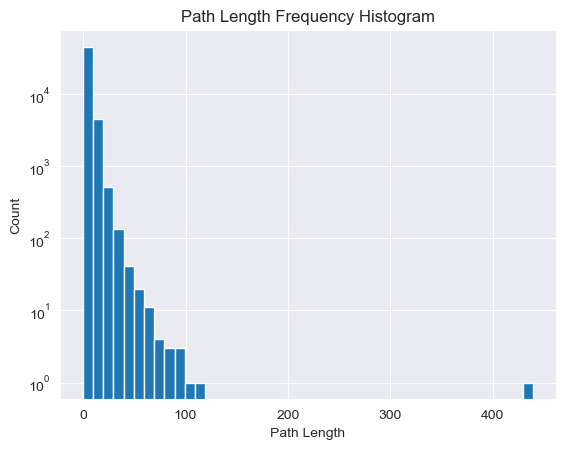

In [57]:
df_finished_path['path_length'].plot.hist(bins=np.arange(-0.5,440.5, 10), edgecolor='white', logy=True)
plt.xlabel("Path Length")
plt.ylabel("Count")
plt.title("Path Length Frequency Histogram")

From the histogram, we could find that the path length mainly concentrates on the range(0, 100). There are also outliers lie at 400+. In order to remove the special situations during the game playing, we set the range of bins to 10. And we consider that the path length frequency in each bin, which is smaller than 10, as outliers. We remove the path length larger than 70.


In [58]:
df_finished_path_rm_outlier = df_finished_path[df_finished_path['path_length'] <= 70]

We also find there are data whose path_length equals to 0. It means that the target article is same to to source one. We also remove this situation.

In [60]:
df_finished_path_rm_outlier = df_finished_path_rm_outlier[df_finished_path_rm_outlier['path_length'] != 0]

Text(0.5, 1.0, 'Path Length Frequency Histogram without Outliers')

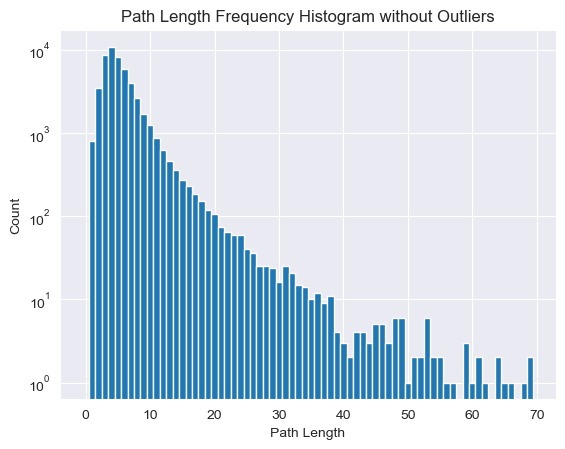

In [63]:
df_finished_path_rm_outlier['path_length'].plot.hist(bins=np.arange(-0.5,70.5,1), edgecolor='white', logy=True)
plt.xlabel("Path Length")
plt.ylabel("Count")
plt.title("Path Length Frequency Histogram without Outliers")

##### Variable: rating and path_length

We want to find that whether the rate is related to the path length

In [76]:
## Is rating related to steps?

# use only data with rating
df_rate = df_finished_path_rm_outlier[df_finished_path_rm_outlier['rating']>0]
df_rate.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,source,destination,path_pair
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0,4,14th_century,African_slave_trade,"[(14th_century, Europe), (Europe, Africa), (Africa, Atlantic_slave_trade), (Atlantic_slave_trade..."
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F...,3.0,6,14th_century,John_F._Kennedy,"[(14th_century, Italy), (Italy, Roman_Catholic_Church), (Roman_Catholic_Church, HIV), (HIV, Rona..."
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,2.0,3,14th_century,Fire,"[(14th_century, China), (China, Gunpowder), (Gunpowder, Fire)]"
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rainbow,1.0,5,14th_century,Rainbow,"[(14th_century, Time), (Time, Isaac_Newton), (Isaac_Newton, Light), (Light, Color), (Color, Rain..."
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,3.0,3,14th_century,Rainbow,"[(14th_century, Time), (Time, Light), (Light, Rainbow)]"


We draw the boxplot with the variable data path_length and rating.

In [83]:
print('Average steps for each rating')
for i in range(5):
    print('rating =',i+1)
    print('number:',df_rate[df_rate.rating == i+1].path_length.count(), 'mean:',df_rate[df_rate.rating == i+1].path_length.mean())

Average steps for each rating
rating = 1
number: 8542 mean: 3.6661203465230625
rating = 2
number: 8792 mean: 5.001592356687898
rating = 3
number: 7261 mean: 6.645503374190882
rating = 4
number: 2746 mean: 9.02804078659869
rating = 5
number: 1150 mean: 11.475652173913044


Text(0.5, 0, 'rating')

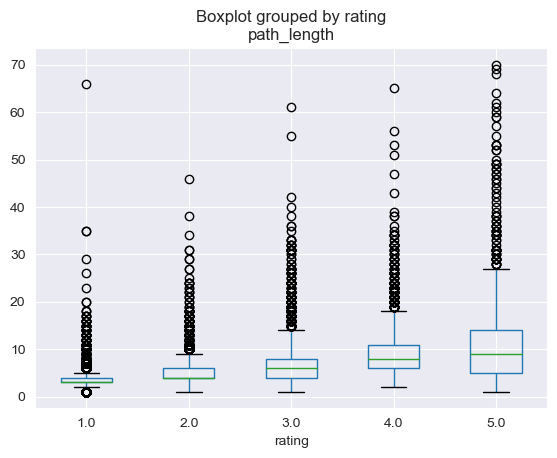

In [84]:
# df_rate.plot.scatter(x='steps', y='rating')
df_rate.boxplot(column=['path_length'], by=['rating'])
plt.xlabel("rating")
plt.ylabel("path_length")
plt.title("Boxplot of Path Length and Rating")

From the above plot, we find that the rating is related to the path length. And longer path will have a higher rate. We will delve this part in our later project.

**2. categories.tsv**

We calculate the hierarchical depth of variable category

In [66]:
def calculate_category_length(x):
    string_array = x.split('.')
    return len(string_array)


df_catagories['category_length'] = df_catagories['category'].apply(calculate_category_length)

In [67]:
df_catagories.head(10)

,articles,category,category_length
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain,4
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures,3
2,%C3%85land,subject.Countries,2
3,%C3%85land,subject.Geography.European_Geography.European_Countries,4
4,%C3%89douard_Manet,subject.People.Artists,3


Dataframe **df_catagories** variables

`articles`: the name of the article

`category`: the category that the article belongs to

`category_length`: the hierarchical depth of the variable category

Analyze the data in dataframe df_catagories

##### Variable: category_length

We first count the frequency according to the variable category_length. There are 274 articles which category depth equals to 2. 3448 articles which category depth equals to 3. 1482 articles which category depth equals to 4.

In [69]:
df_catagories['category_length'].value_counts()

3    3448
4    1482
2     274
Name: category_length, dtype: int64

Then, we check the category with different depth in details.

In [70]:
category_dict_1 = {}
category_dict_2 = {}
category_dict_3 = {}

for index, row in df_catagories['category'].items():
    string_path_pair = []
    string_array = row.split(".")
    for index in range(len(string_array)):
        if index == 1:
            category_dict_1[string_array[index]] = category_dict_1.get(string_array[index], 0) + 1
        elif index == 2:
            category_dict_2[string_array[index]] = category_dict_2.get(string_array[index], 0) + 1
        elif index == 3:
            category_dict_3[string_array[index]] = category_dict_3.get(string_array[index], 0) + 1

We check the categories at the depth 1. Key is the category and the value is the number of articles in this cateogory.

In [72]:
print("There are {} categories at depth 1".format(len(category_dict_1)))
category_dict_1

There are 15 categories at depth 1


{'History': 545,
 'People': 689,
 'Countries': 229,
 'Geography': 1084,
 'Business_Studies': 88,
 'Science': 1122,
 'Everyday_life': 374,
 'Design_and_Technology': 254,
 'Music': 97,
 'IT': 85,
 'Language_and_literature': 196,
 'Mathematics': 45,
 'Religion': 134,
 'Art': 38,
 'Citizenship': 224}

We check the categories at the depth 2. Key is the category and the value is the number of articles in this cateogory.

In [73]:
print("There are {} categories at depth 2".format(len(category_dict_2)))
category_dict_2

There are 101 categories at depth 2


{'British_History': 158,
 'Historical_figures': 108,
 'European_Geography': 139,
 'Artists': 38,
 'Currency': 14,
 'General_history': 80,
 'Military_History_and_War': 71,
 'Physics': 226,
 'Sports_events': 22,
 'Storms': 33,
 'Recent_History': 48,
 'Geology_and_geophysics': 76,
 'Natural_Disasters': 39,
 'Railway_transport': 84,
 'Sports_and_games_people': 45,
 'Biology': 704,
 'Performers_and_composers': 59,
 'Computing_hardware_and_infrastructure': 20,
 'Companies': 18,
 'Novels': 39,
 'Musical_genres_styles_eras_and_events': 46,
 'Everyday_life': 27,
 'Geography_of_the_Middle_East': 36,
 'Ancient_History_Classical_History_and_Mythology': 87,
 'Religious_movements_traditions_and_organizations': 35,
 'Theatre': 32,
 'Geographers_and_explorers': 21,
 'Geography_of_Great_Britain': 124,
 'Religious_texts': 18,
 'African_Geography': 137,
 'Geography_of_Asia': 106,
 'Writers_and_critics': 71,
 'USA_Presidents': 37,
 'Drink': 15,
 'Art': 36,
 'Business': 28,
 'Chemistry': 192,
 'Environment

We check the categories at the depth 3. Key is the category and the value is the number of articles in this cateogory.

In [74]:
print("There are {} categories at depth 3".format(len(category_dict_3)))
category_dict_3

There are 27 categories at depth 3


{'British_History_1500_and_before_including_Roman_Britain': 73,
 'European_Countries': 56,
 'Space_Astronomy': 105,
 'Health_and_medicine': 109,
 'General_Physics': 55,
 'Mammals': 114,
 'Plants': 108,
 'British_History_15001750': 29,
 'Asian_Countries': 37,
 'Middle_Eastern_Countries': 18,
 'Chemical_compounds': 42,
 'Chemical_elements': 119,
 'General_Biology': 51,
 'Birds': 161,
 'Insects_Reptiles_and_Fish': 72,
 'Dinosaurs': 59,
 'General_Chemistry': 21,
 'African_Countries': 57,
 'Central_and_South_American_Countries': 48,
 'Space_transport': 33,
 'British_History_17501900': 24,
 'Organisms': 19,
 'British_History_Post_1900': 18,
 'Electricity_and_Electronics': 20,
 'Evolution_and_reproduction': 11,
 'Materials_science': 10,
 'The_Planets': 13}

**3. articles.tsv**

We create the column **num** as the number index

In [96]:
## record index and change index to articles names

df_article['num'] = df_article.index.copy(deep = True)
df_article.index = df_article['articles']

Change the withdraw operation to -1

In [99]:
## add withdraw '<'
df_article.loc['<'] = -1

In [100]:
df_article.head(10)

,articles,num
articles,,
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0
%C3%85land,%C3%85land,1
%C3%89douard_Manet,%C3%89douard_Manet,2
%C3%89ire,%C3%89ire,3
%C3%93engus_I_of_the_Picts,%C3%93engus_I_of_the_Picts,4
%E2%82%AC2_commemorative_coins,%E2%82%AC2_commemorative_coins,5
10th_century,10th_century,6
11th_century,11th_century,7
12th_century,12th_century,8
